In [28]:
import pandas
import numpy
from pandasql import sqldf
import matplotlib.pyplot as plt

business_df=pandas.read_json("/Users/Earl/Desktop/Coursera Project/yelp_academic_dataset_business.json",lines=True) #creates business dataframe
AZ_business_df = business_df[business_df['state'] == 'AZ'].copy() #filter for the state of arizona
AZ_business_df = AZ_business_df.map(lambda x: x.strip() if isinstance(x, str) else x) #trim off the whitespace from the dataframe

#print(AZ_business_df['city'].unique()) # check for unqique cities and any off instances of Tuscon used as check and found Tucson Tuscon Tuson South Tucson(including since its in Tuscon) Tucson, Arizona and TUCSON AP
tucson_variant_replace_dict={
    'Tuscon':'Tucson',
    'tucson':'Tucson',
    'Tucson, Arizona':'Tucson',
    'TUCSON AP': 'Tucson',
    'TUSCON' : 'Tucson',
    'TUCSON' : 'Tucson',
    'Tuson' : 'Tucson',
    'Tuscon' :'Tucson',
    'South Tucson': 'Tucson'
} 
AZ_business_df['city'].replace(tucson_variant_replace_dict) #create a dictionary of bad Tucson values and replace them with "Tucson" this could have been done in a simplier fashion


Tucson_business_df = AZ_business_df[AZ_business_df['city'] == 'Tucson'].copy() #generate the tucson business dataframe
Tucson_business_attributes_df=Tucson_business_df[['business_id','attributes']] #seperates out the attributes to a seperate dataframe
Tucson_business_hours_df=Tucson_business_df[['business_id','hours']] #seperates out the business hours to a seperate dataframe

Tucson_business_df.drop(columns=['attributes', 'hours'],inplace=True) # removes the hours and attributes from original dataframe

Tucson_business_df.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
16,rBmpy_Y1UbBx8ggHlyb7hA,Arizona Truck Outfitters,625 N Stone Ave,Tucson,AZ,85705,32.229872,-110.972342,4.5,10,1,"Automotive, Auto Parts & Supplies, Auto Custom..."
45,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,0,"Restaurants, Chinese"
56,txyXRytGjwOXvS8s4sc-WA,Smoothie King,1070 E Tucson Marketplace Blvd,Tucson,AZ,85713,32.186794,-110.954765,3.0,29,1,"Vitamins & Supplements, Ice Cream & Frozen Yog..."
67,eYxGFkxo6m3SYGVTh5m2nQ,Big Boyz Toyz Motorcycle Rentals,4158 E Grant Rd,Tucson,AZ,85712,32.250324,-110.903655,4.5,8,1,"Towing, Hotels & Travel, Automotive, Motorcycl..."


In [29]:
Tucson_business_hours_df.head(5)

,business_id,hours
2,tUFrWirKiKi_TAnsVWINQQ,"{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
16,rBmpy_Y1UbBx8ggHlyb7hA,"{'Monday': '0:0-0:0', 'Tuesday': '8:0-17:0', '..."
45,wghnIlMb_i5U46HMBGx9ig,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
56,txyXRytGjwOXvS8s4sc-WA,"{'Monday': '0:0-0:0', 'Tuesday': '7:0-21:0', '..."
67,eYxGFkxo6m3SYGVTh5m2nQ,"{'Monday': '8:30-18:0', 'Tuesday': '8:30-18:0'..."


In [30]:
Tucson_business_attributes_df.head(5)

,business_id,attributes
2,tUFrWirKiKi_TAnsVWINQQ,"{'BikeParking': 'True', 'BusinessAcceptsCredit..."
16,rBmpy_Y1UbBx8ggHlyb7hA,"{'DriveThru': 'False', 'BusinessAcceptsCreditC..."
45,wghnIlMb_i5U46HMBGx9ig,"{'WiFi': ''no'', 'BusinessParking': '{'garage'..."
56,txyXRytGjwOXvS8s4sc-WA,"{'RestaurantsPriceRange2': '2', 'BusinessParki..."
67,eYxGFkxo6m3SYGVTh5m2nQ,None


In [78]:

pysqldf= lambda q: sqldf(q, globals())
Tucson_business_df['postal_code'].replace('', numpy.nan, regex=True)    #remove null zipcodes discovered during quality test

query = '''
    SELECT postal_code,
           AVG(stars * review_count) AS weighted_stars,
           SUM(review_count) AS total_review_count
    FROM Tucson_business_df
    WHERE postal_code IS NOT NULL
    GROUP BY postal_code
    ORDER BY weighted_stars DESC;
''' #create the query to make the weighted stars which is stars times the number of reviews then get the review count.
Postcode_valueby_weightedstars=pysqldf(query)  # query data
Postcode_valueby_weightedstars.head(5) 

,postal_code,weighted_stars,total_review_count
0,32246,477.000000,159
1,85701,325.690828,27802
2,85718,225.818314,20821
3,85716,225.749507,29472
4,85619,225.500000,102


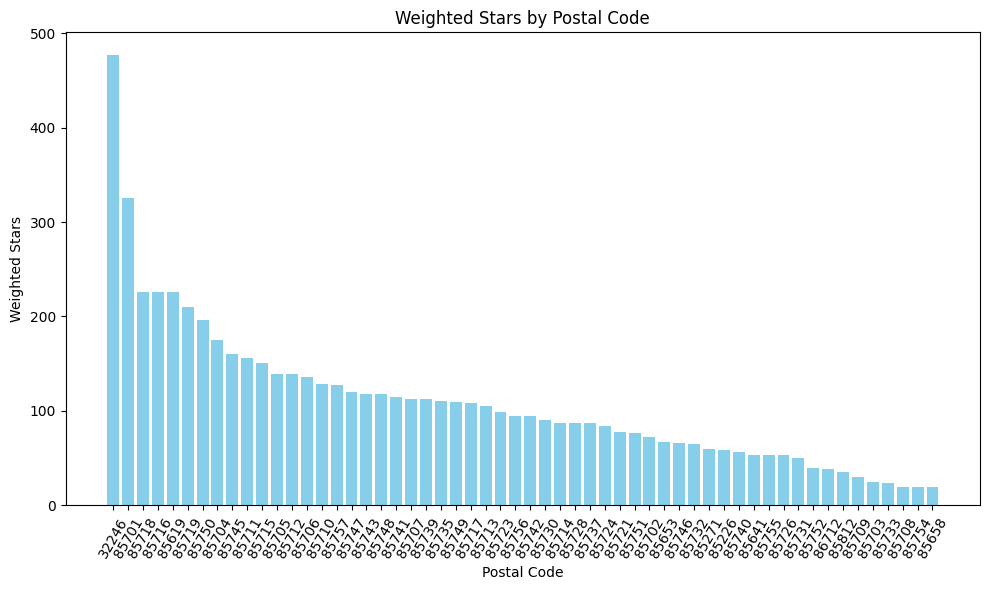

In [91]:
# Extract data
postal_codes = Postcode_valueby_weightedstars['postal_code']
weighted_stars = Postcode_valueby_weightedstars['weighted_stars']

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(postal_codes, weighted_stars, color='skyblue')

# Add labels and title
plt.xlabel('Postal Code')
plt.ylabel('Weighted Stars')
plt.title('Weighted Stars by Postal Code')
plt.xticks(rotation=60)  

# Show plot
plt.tight_layout()  
plt.show()


In [97]:
# import statsmodels.api as sm

# from statsmodels.formula.api import ols
# #print(Postcode_valueby_weightedstars[['postal_code','weighted_stars']])
# model = ols('weighted_stars ~ C(postal_code)', data=Postcode_valueby_weightedstars[['postal_code','weighted_stars']]).fit()

# # Perform ANOVA
# anova_table = sm.stats.anova_lm(model, typ=2)
# print(anova_table)

# # so the issue is im not doing this right, the input of the anova for python needs to just be your entire data frame and you and group it by zipcodes for that
# #so for the this step you need just postcodes and there review weight 

C:\Users\Earl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal

In [ ]:
# import matplotlib.pyplot as plt
# import statsmodels.api as sm

# # Assuming 'data' is your dataset variable containing the data you want to analyze
# # Replace 'data' with your actual dataset
# # Example: data = your_dataframe['column_name'].values

# # Create Q-Q plot
# sm.qqplot(data, line='s')  # 's' line: standardized line (unit variance and zero mean)
# plt.title('Q-Q Plot')
# plt.xlabel('Theoretical quantiles')
# plt.ylabel('Sample quantiles')
# plt.show()

NameError: name 'data' is not defined